In [1]:
from collections import defaultdict, namedtuple
import itertools
import math
import random
import time
import gym
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import train_utils

# Aprendizaje por refuerzo

**DSLAB - Rubén Rodríguez Fernández**

Qué hemos visto hasta ahora en aprendizaje máquina:

 * Aprendizaje **supervisado**: Las observaciones, $X$, tienen asociada una etiqueta, $y$, y el objetivo es encontrar un función $f: X \mapsto y$. Por ejemplo, clasificación y regresión.
 * Aprendizaje **no-supervisado**: Las observaciones , $X$, no tienen una etiqueta asociada y el objetivo es encontrar relaciones entre las observaciones. Por ejemplo, clustering y estimación de densidades.

Aprendizaje **reforzado**: 

* Un agente interactua con el entorno a través de acciones y obtiene una recompensa. 
* El objetivo es maximizar esa recompensa. 
* La recompensa no tiene por que ser inmediata, por lo que un agente puede realizar varias acciones antes de recibir una recompensa.

Ejemplos de aprendizaje reforzado:

* Juegos - El agente, jugador, trata de ganar (recompensa positiva) sin perder (recompensa negativa). P.ej, AlphaGo Zero. 
* Invertir en valores - Ganar dinero (positivo), perder (negativo)
* Planning - Elaborar una ruta. La ruta puede estar penalizada (negativa) por el número de pasos

Ejemplos de recompensas:

* Correr un maratón: El objetivo es llegar lo antes posible (penalización por tiempo). Alimentarse o hidratarse hace que tengamos una penalización a corto plazo, pero evitará que perdamos más tiempo a largo plazo.
* Jugar al tenis: Hacer un punto (recompensa positiva), que te hagan un punto (negativa).
* Estudiar para un examen: A corto plazo, estudiar puede tener una recompensa negativa porque no nos guste, pero a largo plazo aprobaremos el examen y no tendremos que estudiar (recompensa positiva)

¿Cómo el **agente** realiza la **interacción** con el **entorno**? La interacción se lleva a cabo en timesteps discretos, $ t = 0, 1, \ldots $. En cada iteración se realizan las siguientes tareas:

* El agente recibe una representación del estado actual del entorno, $s_t^a$,
* que tiene la información necesaria para realizar la acción, $a_t$, donde $a_t$ pertenece al conjunto de acciones disponibles en el estado $s_t$, $a_t \in A(s_t^a)$
* y obtiene una recompensa $r_t$ ($r \in \mathbb{R}$).

Representación gráfica de la interacción de un agente con el entorno.

<img src="images/reinforcement_learning_diagram.png" alt="rl diagram" width="300" class="center"/>

El estado del entorno, $s_t^e$, puede ser igual o contener más información que el estado que recibe el agente, $s_t^a$, dando lugar a dos tipos de entornos:
 * **Observable**: El agente es capaz de percibir toda la información del entorno, $s_t^a = s_t^e$. Por ejemplo, en el ajedrez el entorno es el tablero y la colocación de las piezas, en este caso un agente (jugador) es capaz de percibir todo el entorno.
 * **Parcialmente observable**: El agente es capaz de observar solo una parte del entorno $s_t^a \ne s_t^e$. Por ejemplo, en el juego flappy birds un agente (jugador) sólo percibe el entorno que se muestra en la pantalla, pero no tiene información sobre los obstaculos que hay después. 

La **historia** de un agente, $H_t$, es el secuencia de estados, acciones y recompensas hasta el instante $t$. $H_t = s_0, a_0, r_0, \ldots, s_t, a_t, r_t$.

**Objetivo**: máximizar la secuencia cumulativa de recompensas:

* Según la hipótesis de la recompensa (Rewards hypothesis), todos los objetivos pueden ser descritos como la maximización de la esperanza cumulativa de la recompensa. 
* En algunos casos es mejor sacrificar las recompensas a corto plazo para obtener una recompensa mayor a largo plazo.

## Markov decision process

* Un proceso de decision de Markov (MDP) proporciona un marco de trabajo matemático para sistemas de tomas de decisión donde hay aleatoriedad en las acciones tomadas. 
* Es un enfoque para algunos problemas de aprendizaje por refuerzo.

Un MDP está compuesto por los siguientes componentes:

* El estado, $S$,
* El conjunto de acciones, $A$, y las acciones disponibles para el estado $s$, $A(s)$,
* La probabilidad de transición $T(s,a,s\prime) \sim \mathbb{P}(s\prime|s,a)$, que es la probabilidad de acabar en el estado $s\prime$ al realizar la acción $a$ en el estado $s$,
* Y la recompensa $R(s,a,s\prime)$ que es la recompensa esperada al pasar de $s$ a $s\prime$ a través del la accción $a$.

Además, se tiene que cumplir la propiedad de Markov:

$\mathbb{P}(S_{t+1}|S_t) = \mathbb{P}(S_{t+1}|S_t, \ldots, S_0)$

que implica que el estado $s_t$ captura toda la información relevante de la historia (el **futuro** es independiente del **pasado** dado el **presente**).

**Objetivo**: Encontrar una policy $\pi$ que permita seleccionar la acción a tomar, $a_t$, en el estado $s_t$ ($\pi(s_t) = a_t$) que maximize una función de la secuencia cumulativa de recompensas.

Normalmente, esta función de la secuencia cumulativa de recompensas es la esperanza de la suma de recompensas descontada sobre un horizonte infinito:

$\mathbb{E}[\sum^\infty_{t=0} \gamma^t R(s_t,a_t,s_{t+1})]$

Donde $\gamma$ es el factor de descuento tal que $0 \le \gamma \le 1$.

El factor de descuento es un parámetro muy importante, que permite establecer cuan **lejos** el método tiene que mirar en el horizonte de recompensas:

* Un factor de descuento cercano a cero indica que solo las recompensas **inmediatas** son consideradas, 
* Un factor de descuento a uno permite considerar un **horizonte mayor**. 

¿Cuál es el mejor factor de descuento? Como en la mayoría de los parámetros en ML, esto dependerá del problema. En la práctica, en la mayoría de los casos se elige $\gamma = 0.9$.

**Definiciones**: 

La policy óptima, $\pi^*$, se representa como :

$\pi^* = argmax_\pi \mathbb{E} [\sum^\infty_{t=0} \gamma^t R(s_t) |\pi]$

Con esta información podemos definir la función Value, $V(s)$, que define la recompensa esperada en el futuro empezando desde el estado $s$ siguiendo la política $\pi$:

$V^\pi(s) = \mathbb{E}[\sum^\infty_{t=0} \gamma^t R(s_t) |\pi, s_0=s]$

y podemos escribir la política óptima en términos de $V(s)$:

$\pi^* = argmax_a \sum_{s\prime} T(s, a, s\prime) * V^{\pi^*} (s\prime)$

# Métodos para resolver problemas de aprendizaje reforzado

Para visualizar como funcionan los algoritmos que vamos a ver con un problema de aprendizaje reforzado llamado FrozenLake-v0:

<img src="images/frozen_lake.png" alt="frozen lake" width="300" class="center"/>

**Descripción del juego**: 
* caminar por un lago helado (F) para llegar a la meta (G), 
* evitando caerse al agua en las zonas donde la capa de hielo es menor (nos caeríamos) (H). 
* los nodos terminales, que indican que el juego se acaba, son G y H.
* Las acciones que puede realizar el agente son moverse a la izquierda, derecha, arriba y abajo. 
* El número de estados son 16, y representa cada una de las celdas del grid.

Fuente imagen: 
https://academy.dataiku.com/latest/tutorial/machine-learning/reinforcement-learning-q-learning.html

**Breve introduducción al paquete gym de Openai**

Lo primero que tenemos que hacer es crear un entorno (ver otros entornos en https://gym.openai.com/), y resetearlo para llevarlo al estado original:

In [2]:
env = gym.make('FrozenLake-v0', is_slippery=True)
env.reset()

0

Para visualizar el entorno utilizamos la función render. Esta función tiene un parámetro **mode** que nos permitirá utilizar diferentes tipos de representaciones como texto o gráfica, en el entorno frozenlake solo tenemos disponible la representación basada en texto

In [3]:
env.render()


SFFF
FHFH
FFFH
HFFG


El conjunto de posibles acciones se encuentra en el atributo **action_space**. En FrozenLake, solo disponemos de cuatro acciones: izquierda, abajo, derecha y arriba (0, 1, 2, 3) respectivamente.

In [4]:
env.action_space

Discrete(4)

El número de posibles estados se encuentra el atributo **nS**. En este problema son 16 (es un grid de 4x4)

In [5]:
env.nS

16

Para realizar una acción utilizamos el método **step**, que nos devuelve el nuevo estado, recompensa, un flag que nos indica si el juego ha terminado o no, e información sobre la transición

In [6]:
state, reward, done, info = env.step(2) 
print(state, reward, done)

1 0.0 False


In [7]:
info

{'prob': 0.3333333333333333}

Si visualizamos de nuevo el entorno veremos como el agente se ha movido de la celda inicial

In [8]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


Una vez terminado el entrenamiento podemos cerrar el entorno con el método **close**.

In [9]:
env.close()

## Programación dinámica

In [10]:
dp_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'}
}

### Value iteration

* Value iteration es un método para calcular la policy y funcion value óptima para un MDP,
* Este método parte de la premisa que la función value, $V(s)$, es suficiente para aprender la policy óptima. 
* Por lo tanto, este método primero cálcula $V(s)$, y posteriormente $\pi^*$. 

El método de value iteration utiliza la definición de $V(s) \equiv V^\pi(s)$, con las definiciones anteriores llegando a:

$V(s) = R(s) + \gamma max_a \sum_{s\prime} T(s, a, s\prime) V(s\prime)$

Con esta definición de $V(s)$, value iteration se define como:

$V_{t+1}(s) = R(s) + \gamma max_a \sum_{s\prime} T(s, a, s\prime) V_t(s\prime)$

donde se empieza con una función valor aleatoria, $V_0$, y se actualiza hasta que converja. En la práctica, el algoritmo se detiene cuando los cambios de la función valor son menores a un umbral, en este caso theta.

El psudo-código de value iteration es el siguiente (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/value_iteration.png" alt="value iteration" width="600" class="center"/>

In [11]:
def one_step_lookahead(env, state, V, discount_factor):
        """
        CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
        
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            A[a] = sum([prob * (reward + discount_factor * V[next_state]) 
                        for prob, next_state, reward, done in env.P[state][a]])
        return A

In [12]:
def value_iteration(env, theta=0.0001, discount_factor=1.0, return_history=True):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """

    V_history = []
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(env, s, V, discount_factor)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value
        
        if return_history:
            V_history.append(V.copy())
            
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(env, s, V, discount_factor)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    if return_history:
        return policy, V, V_history
    else:
        return policy, V

**Demostración de value iteration en custom frozenlake**

In [13]:
plot_func = train_utils.multi_display(train_utils.display_lake_policy, None, train_utils.display_lake_value_history)
train_utils.display_learning_widget(value_iteration, dp_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

Ahora vamos a probar a jugar una partida

In [14]:
frozen_env = gym.make('custom-FrozenLake-v0', prob_action=0.8, rg_hole=0, rg_floor=0)
p_frozen, v_frozen = value_iteration(frozen_env, return_history=False, discount_factor=1)

In [15]:
train_utils.play_episode(frozen_env, p_frozen)

  (Right)
SFFF
FHFH
FFFH
HFFG


None

Rewards 1


In [16]:
train_utils.display_lake_policy(frozen_env, p_frozen)

↓,↑,↑,↑
←,H,↑,H
↑,↓,←,H
H,→,↓,G


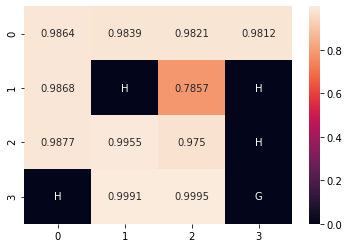

In [17]:
train_utils.display_lake_value(frozen_env, v_frozen)

### Policy iteration

Policy iteration es un método para calcular la política óptima para un MDP. El algoritmo está compuesto por dos métodos:

* policy evaluation: se calcula la función value (también llamada state-value) para una policy arbitraria.
* policy improvement: se mejora la policy utilizando la función value del paso anterior.

**Evaluation**:
 * Calculamos la función value utilizando una policy $\pi$ con las siguientes ecuaciones:

$V_\pi(s) = \mathbb{E}[G_t | S_t = s]$
$= \mathbb{E}[R_{t+1} + \gamma V_\pi(s_{t+1}) | S_t = s]$
$= \sum_{a} \pi(a|s) \sum_{s\prime, r} p(s, a, s\prime) * [r + \gamma V(s\prime)]$

**Improvement**:

* Una vez hemos calculado la función value $V_\pi(s)$ podemos utilizarla para mejorar la policy. 
* Para mejorar la política, se compara la acción seleccionada para un estado usando la política con la mejor acción utilizando la función valor, y en caso de ser diferentes, se actualiza la política.

El pseudo-código de policy iteration es el siguiente (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/policy_iteration.png" alt="policy iteration" width="600" class="center"/> 

In [18]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.001):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)


In [19]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(env, s, V, discount_factor)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V


**Demostración de policy iteration en custom frozenlake**

In [20]:
plot_func = train_utils.multi_display(train_utils.display_lake_policy, None, train_utils.display_lake_value_history)
train_utils.display_learning_widget(policy_improvement, dp_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Monte Carlo

* Los métodos vistos hasta ahora de programación dinámica tienen una gran limitación, ya que asumen que se tiene un conocimiento completo del entorno,
* En la práctica, esto no es siempre es así.
* Los métodos de monte carlo solucionan este problema aprendiendo del entorno a través de la experiencia generada al interaccionar con el entorno.
* Estos métodos tienen una gran varianza, pero no está sesgados. 
* Convergencia asintótica.

¿Cómo se definen la experiencia?

* La experiencia se agrupa en episodios (en el caso de los juegos, un episodio podría ser una partida),
* cada episodio esta compuesto de una secuencia ordenada de la 4-upla (estado, acción, recompensa y proximo estado)
* utilizando esta experiencia, podemos calcular la función state-action
* y mejorarla en cada episodio

¿Cómo estimamos la policy?

* Generamos una función state-action $Q(s,a)$ aleatoria,
* y creamos una policy $\pi$ utilizando $Q(s,a)$,
* Posteriormente, generamos un episodio siguiendo la policy $\pi$,
* Para cada estado y acción $s, a$ en el episodio, buscamos la primera vez que aparecen en el episodio,
* y calculamos la recompensa cumulativo desde ese punto,
* actualizamos $Q(s, a)$ con la media de todas las recompensas cumulativas para $s, a$.

Psuedo código del método montecarlo para estimar $\pi$ (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/montecarlo.png" alt="montecarlo" width="600" class="center"/> 

In [21]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [22]:
def mc_control_epsilon_greedy(env, num_episodes, episode_steps=100, discount_factor=1.0, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(1, num_episodes + 1)):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(episode_steps):
            if encode_state:
                next_state = encode_state(next_state)
                
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return dict(Q)

In [23]:
mc_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'},
    'epsilon': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'epsilon'},
    'num_episodes': {'values': (10**3, 10**4, 3 * 10**4, 6 * 10**4, 10**5, 10**6, 10**7), 'default': 10**4, 'text': 'num_episodes'},
}

**Demostración de Monte Carlo en frozenlake**

In [24]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(mc_control_epsilon_greedy, mc_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Temporal-difference Learning

* TD-Learning es una combinación de las técnicas Monte Carlo y programación dinámica,
* Como montecarlo, TD funciona con las experiencias y no requiere de un modelo del entorno
* Al igual que la programación dinámica, TD utiliza bootstrapping para hacer las actualizaciones.
* La convergencia de TD suele aprender más rápido pero están sesgados (a las condiciones iniciales),
* Por otra parte, los métodos basados en Monte Carlo no están sesgados pero requieren de más iteraciones para llegar a un resultado similar a TD.

<!-- 
The main problem with TD learning and DP is that their step updates are biased on the initial conditions of the learning parameters. The bootstrapping process typically updates a function or lookup Q(s,a) on a successor value Q(s',a') using whatever the current estimates are in the latter. Clearly at the very start of learning these estimates contain no information from any real rewards or state transitions.

If learning works as intended, then the bias will reduce asymptotically over multiple iterations. However, the bias can cause significant problems, especially for off-policy methods (e.g. Q Learning) and when using function approximators. That combination is so likely to fail to converge that it is called the deadly triad in Sutton & Bart.

Monte Carlo control methods do not suffer from this bias, as each update is made using a true sample of what Q(s,a) should be. However, Monte Carlo methods can suffer from high variance, which means more samples are required to achieve the same degree of learning compared to TD.

In practice, TD learning appears to learn more efficiently if the problems with the deadly triad can be overcome. Recent results using experience replay and staged "frozen" copies of estimators provide work-arounds that address problems - e.g. that is how DQN learner for Atari games was built. -->

Las actualizaciones en TD-Learning tienen normalmente la siguiente forma:
    
* $V(s_t) = V(s_t) + \alpha[R_{t+1} + \gamma V(s_{t+1}) - V(s_{t})]$,
* Estimacion = Valor actual + $\alpha$ [Nuevo valor - Valor actual],
* donde $0 \le \alpha \le 1$  es el parámetro de aprendizaje que regula las actualizaciones.
* El término $R_{t+1} + \gamma V(s_{t+1}) - V(s_{t})$ es el "error", de la estimación $V(s_{t})$ y la mejor estimación $R_{t+1} + \gamma V(s_{t+1})$.


En las siguientes secciones vamos a ver dos métodos basados en temporal-difference, que tienen la siguiente forma:

* El objetivo es calcular la función state-action ($Q(S, A)$)
* El método se repite para un cojunto de episodios predeterminado:
* Dentro del episodio, el método escoge una acción $a$ utilizando una policy derivada de $Q(S, A)$.
* Ejecuta la acción, obteniendo el nuevo estado $s\prime$, y la recompensa $r$,
* y actualizan $Q(S, A)$.
    

Las diferencias de los dos métodos radican en cómo se actualiza $Q(S, A)$:

* SARSA: Es un método on-policy. La actualización de los q-values se realiza utilizando la policy actual.
* Q-Learning: Es un método off-policy. La actualización de los q-values se realiza utilizando el siguiente estado $s\prime$ y la acción $a\prime$ utilizando un enfoque greedy.

In [25]:
td_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'},
    'alpha': {'values': np.arange(0, 1.1, 0.1), 'default': 0.5, 'text': 'alpha'},
    'epsilon': {'values': np.arange(0, 1.1, 0.1), 'default': 0.1, 'text': 'epsilon'},
    'num_episodes': {'values': (10**3, 10**4,  3 * 10**4, 6 * 10**4, 10**5, 10**6, 10**7), 'default': 10**4, 'text': 'num_episodes'},
}

### SARSA

* SARSA es un método on-policy, por lo que la función $Q(S,A)$ se actualiza utilizando la policy actual.
* En la actualización, el método elige una acción $a\prime$ para el estado $s\prime$ utilizando la policy derivada de $Q(S,A)$,
* y actualiza $Q(s,a) =  Q(s, a) + \alpha[R + \gamma Q(s\prime, a\prime) - Q(s, a)]$.
* Recordar que tiene una forma similar al "error" en TD.
* La acción $a\prime$ -> $a$, y $s\prime$ -> $s$, y pasamos a la siguiente iteración

Psuedo código del método SARSA (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/sarsa.png" alt="sarsa" width="600" class="center"/> 

### Q-Learning

* Q-Learning es un método off-policy, por lo que la función $Q(S,A)$ se actualiza utilizando un enfoque greedy.
* En la actualización, el método elige una acción $a\prime$ para el estado $s\prime$ utilizando un enfoque greedy,
* y actualiza $Q(s,a) =  Q(s, a) + \alpha[R + \gamma max_{a\prime} Q(s\prime, a\prime) - Q(s, a)]$.
* Recordar que tiene una forma similar al "error" en TD.
* El estado $s\prime$ -> $s$, y pasamos a la siguiente iteración


Psuedo código del método q learning (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/qlearning.png" alt="q learning" width="600" class="center"/> 

### Implementaciones de SARSA y Q-Learning

In [26]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        
        # Reset the environment and pick the first action
        state = env.reset()
        if encode_state:
            state = encode_state(state)
            
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            if encode_state:
                next_state = encode_state(next_state)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        

    return dict(Q)

**Demostración de sarsa en frozenlake**

In [27]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(sarsa, 
                                    td_params, 
                                    plot_func, 
                                    env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

In [28]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        # Reset the environment and pick the first action
        state = env.reset()

        if encode_state:
            state = encode_state(state)
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():        
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            if encode_state:
                next_state = encode_state(next_state)
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                 
            if done:
                break
                
            state = next_state   
    return dict(Q)

**Demostración de Q-Learning en frozenlake**

In [29]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(q_learning, td_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Otros entornos de gym para prácticar

### Taxi env

**Description**:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    
**Observations**: 
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
**Passenger locations**:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi
    
**Destinations**:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
        
**Actions**:
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger
    
**Rewards**: 
There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    

In [30]:
taxi_env = gym.make('Taxi-v3')

In [31]:
taxi_env.render()
taxi_env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Podéis utilizar la función cached_call que persite las ejecuciones entre sesiones para probar diferentes combinaciones, tiene como parámetros la función que vais utilizar para resolver el problema, el nombre del entorno, un diccionario con los argumentos para crear el entorno, y otro diccionario con los parámetros del método. El resultado es una tupla con el resultado/s del método, y el entorno

In [32]:
Q_mc, taxi_env = train_utils.cached_call(q_learning, 'Taxi-v3', {}, method_kwargs={'num_episodes':10**4})

También podéis utilizar la función directamente

In [33]:
# Q_mc = q_learning(taxi_env, num_episodes=10**4)

Para reproducir un episodio podéis utilizar la función play_episode, que recibe como parámetro el entorno y una policy

In [35]:
train_utils.play_episode(taxi_env, train_utils.get_policy_from_q(Q_mc, taxi_env.nS, taxi_env.action_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


None

Rewards 20


### MountainCar 

Ver descripción del entorno en https://gym.openai.com/envs/MountainCar-v0/ y https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [36]:
car_env = gym.make('MountainCar-v0')
car_env.reset()
car_env.render()

True

In [37]:
car_env.close()

In [38]:
class MountainCairStateEncoder:
    
    def __init__(self, env, num_buckets_v = 20, num_buckets_x = 20):
        self.env = env
        self.num_buckets_v = num_buckets_v
        self.num_buckets_x = num_buckets_x
        
        self.min_x = env.unwrapped.min_position
        self.max_x = env.unwrapped.max_position
        
        self.min_v = -env.unwrapped.max_speed
        self.max_v = env.unwrapped.max_speed
    
        self.nS = self.num_buckets_v * self.num_buckets_x
        
    def get_bucket(self, vmin, vmax, v, num_buckets):
        bucket_size = (vmax - vmin) / num_buckets
        return int((v - vmin) // bucket_size)
        
    def __call__(self, state):
        x, v = state
        bucket_x = self.get_bucket(self.min_x, self.max_x, x, self.num_buckets_x)
        bucket_v = self.get_bucket(self.min_v, self.max_v, v, self.num_buckets_v)
        return int(bucket_x * self.num_buckets_v + bucket_v)
    
    def __hash__(self):
        return hash((self.num_buckets_v, self.num_buckets_x))

In [39]:
car_state_encoder = MountainCairStateEncoder(car_env)
Q_car, car_env = train_utils.cached_call(q_learning, 'MountainCar-v0', {}, {'num_episodes': 3 * 10**3, 'encode_state':car_state_encoder})
p_car = train_utils.get_policy_from_q(Q_car, car_state_encoder.nS, car_env.action_space.n)

In [40]:
train_utils.play_episode(car_env, p_car, encode_state=car_state_encoder, max_steps=2500)
car_env.close()

True

Rewards -1.0


# Deep Q-Learning

¿ Qué problemas/limitaciones tienen las técnicas vistas hasta ahora?
* Los enfoques presentados hasta ahora tienen una representación discreta,
* por lo tanto, necesitan mantener una representación explicita de cada estado.
* Normalmente, la función a estimar (funcion value, policy, state-action) se almacena en un diccionario para cada estado.
* Esta solución solo es válida en entornos donde el número de estados es reducidos.

Para poner en contexto esta limitación, consideremos los espacios de posibles acciones de los siguientes juegos:

* Ajedrez: El número de posibles estados válidos se cree que está entre $10^{43}$ y $10^{50}$.
* Go: En un tablero de 19x19, el número de estados es superior a $10^{172}$.
* Animal crossing: Utilizando como observaciones la pantalla de la switch con resolución 1280x720 y una representación RGB, el número de estados sería $3^{921600}$.

Como consecuencia, los métodos que hemos visto hasta ahora no son capaces de funcionar en este tipo de problemas (sin modificaciones):

* En los métodos basados en programación dinámica, value iteration y policy iteration, las actualizaciones se realizan para cada uno de los estados, y se tiene una representación explicita para cada uno de ellos.
* En los métodos basados en montecarlo y temporal-difference, las actualizaciones se realizan en base a la experiencia, y solo se actualizan aquellos pares de estados-acciones que se han visitado. Aún así, la función state-action (Q) no estaría definida en la mayoría de los casos.

¿Cómo solucionamos este problema?:

* Las representaciones de estados discretas asumen que los estados no guardan relación entre si.
* En la mayoría de los casos esto no es así, y algunos estados son similares,
* Y como consecuencia, las acciones resultantes serán similares.
* **Solución**: estimar la función Q utilizando un estimador que sea capaz de explotar estas similaridades para encontrar una representación mas compacta.

¿Y que técnica podemos utilizar para estimar esta función?:

* Cualquiera de las técnicas de aprendizaje supervisado que hemos visto hasta ahora.
* Recordad, que los modelos de aprendizaje supervisado tratan de estimar una función $f: X \mapsto y$ utilizando otra función $\hat{f}: X \mapsto y$.
* En este caso nos centremos en modelos de aprendizaje profundo debido a su habilidad para tratar con problemas de alta dimensionalidad.

Volviendo a Deep Q-Learning, ¿Qué necesitamos?:

* El objetivo es estimar la función state-action Q → Modelo basado en Deep Learning.
* Features del problema → El estado.
* Etiquetas del problema → Los valores esperados de recompensa para cada una de las acciones.
* Función de pérdida → ¿?

¿Cómo se actualizan los valores en Q-Learning?
* La actualización se realiza: $Q(s,a) =  Q(s, a) + \alpha[R + \gamma max_{a\prime} Q(s\prime, a\prime) - Q(s, a)]$,
* Y el término $R + \gamma max_{a\prime} Q(s\prime, a\prime) - Q(s, a)$ representa el error en la estimación.
* **Función de pérdida** → $\delta = Q(s, a) - (R + \gamma max_{a\prime} Q(s\prime, a\prime))$

Ya tenemos todas las herramientas para utilizar Deep Q-Learning, ¿y ahora qué?:

* En la práctica, cuando utilizamos un método off-policy, métodos de aproximación de funciones no lineales y boostrapping, el entrenamiento se vuelve inestable y puede que no converja.
* Este problema es conocido como deadly triad (ver libro de Sutton & Barto).
* El efecto de estos problemas se puede minimizar con **experience replay** y **fixed target**.

**Experience replay**: 

* Guardamos una ventana de experiencias previas con el entorno, 4-uplas (estado, acción, proximo estado, recompensa)
* En cada iteración, en lugar de entrenar con la última "experiencia", entrenamos con una muestra de tamaño aleatorio de la memoria de experiencias
* Al ser muestras aleatorias y no consecutivas, minimizamos el efecto de correlaciones entre experiencias consecutivas.
* Además, el método es más eficiente,
* Y suaviza las actualizaciones, ya que estamos utilizando un conjunto de experiencias para actualizar los pesos, y no una experiencia sola.

**Fixed target**:

* Como en cada step del entorno realizamos una iteración, los valores de la red neuronal que utilizamos para estimar Q varian.
* Esto vuelve el modelo inestable y dificulta su convergencia (oscilaciones).
* Para solucionar este problema se introduce una segunda red neuronal, **Fixed target**, igual a la red neuronal original y con los mismos parámetros.
* La red original se entrena contra los valores obtenidos del modelo **Fixed target**, 
* Y periodicamente, los parámetros de la red original se copian en **Fixed target**.
* Con esto se consigue hacer el entrenamiento mas estable y evitar las oscilaciones.

Ahora al código!

Para implementar el módelo de Deep Q-Learning vamos a utilizar pytorch. Para una breve introducción de la librería ver: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html y la guia de instalación en https://pytorch.org/.

Lo primero que haremos será definir el dispositivo donde se almacenarán los tensores, y donde se realizarán las operaciones del modelo. En este caso, utilizaremos cuda si está disponible, en caso contrario, se ejecutarán en la cpu.

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Priemero definiremos la estructura de datos de replay memory, donde tendremos almacenadas las experiencias previas del modelo para su posterior entrenamiento. Esta estructura de datos se implementa mediante una lista circular, por lo que al llegar a su máxima capacidad, se irán sobreescribiendo los elementos por orden de antiguedad. 

In [42]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    """
        Code from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Ahora ya podemos definir nuestro agente de Deep Q Learning:

* El agente recibe como parámetros los modelos **target_net** y **policy_net**.
* Cada **target_update** episodios, el modelo **target_net** se actualiza con los parámetros de **policy_net**,
* Para ello, antes de cada episodio hay que llamar al método **start_episode()**.
* Las computaciones se llevan a cabo en el dispositivo **device**.
* Se almacenarán hasta **memory_size** 4-uplas de estado, acción, recompensa y nuevo estado, eliminando por orden de llegada cuando se llega a la capacidad total.
* El número de acciones posibles para el agente es **n_actions**.
* Para cada fase de entrenamiento parcial, se entrenará **policy_net** utilizando **batch_size** elementos de la memoria.
* En caso de tener menos de **batch_size** elementos, no se entrenará.
* El valor gammma se regula con el parámetro **gamma**.
* Finalmente, se utilizará una policy epsilón-greedy, que se regula con los parámetros **eps_start**, **eps_end**, **eps_decay**,
* calculándose el epsilón actual como: $\epsilon = \epsilon_{end} + (\epsilon_{start} - \epsilon_{end}) e^{-1 steps / \epsilon_{decay}}$

Y los métodos:

* select_action: Selecciona una acción para el estado **state**  utilizando una policy epsilon-greedy con epsilon decay. En la evaluación, se utilizará el parámetro **trainning** para forzar una policy greedy.
* step: Se almacena un step en la memoria (state, action, next_state, reward), y se llama al método **optiize_model**.
* optimize_model: Se entrena el modelo. Sólo se optimizará cuando el tamaño de la memoria sería superior al tamaño de batch.
* start_episode: Se debe ejecutar antes de empezar el episodio, y permite cada **target_update** episodios, actualizar el modelo **target_net**.

In [43]:
class DQNAgent:
    """
        Base code from (modified): https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """
    
    def __init__(self, policy_net, target_net, device, n_actions, memory_size=10_000, batch_size=128, gamma=0.999, eps_start=0.9, eps_end=0.05, eps_decay=200, target_update=10):
        self.target_net = target_net
        self.policy_net = policy_net
        self.optimizer = optim.RMSprop(policy_net.parameters())
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.target_update = target_update
        self.memory = ReplayMemory(memory_size)
        self.device = device
        self.steps_done = 0
        self.i_episode = 0
        
    def select_action(self, state, trainning=True):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        
        if trainning:
            self.steps_done += 1
        
        if sample > eps_threshold or not trainning:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
        # torch cat concatenates in the given dimension (by default 0)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        
        # Note: gather selects from the tensor self.policy_net(state_batch) with size batch_size x n_actions, 
        # the action that was actually selected for the experience. action_batch is the list of indexes of the selected actions
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        # Note: deatch returns a new Tensor, detached from the current graph
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        # Unsqueeze returns a new tensor with a dimension of size one inserted at the specified position. (insert the batch dimension)
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()
        
    def start_episode(self):
        self.i_episode += 1
        if self.i_episode % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward)
        self.optimize_model()

## CartPole-v0

* A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
* The system is controlled by applying a force of +1 or -1 to the cart. 
* The pendulum starts upright, and the goal is to prevent it from falling over. 
* A reward of +1 is provided for every timestep that the pole remains upright. 
* The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Enlance al entorno: https://gym.openai.com/envs/CartPole-v1/

In [44]:
%%HTML
<video width="320" height="240" controls>
  <source src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CartPole-v1/thumbnail.mp4" type="video/mp4">
</video>

* Creamos el estimador para la función Q del entorno cartpole utilizando DQN. 
* Dado que utilizaremos las imagenes del entorno el modelo será una red neuronal convolucional (podría ser una red fully connected)
* En este caso, se utilizan 3 pares de convolución + batchnorm2d (Comentarios sobre el paper de batch norm https://gist.github.com/shagunsodhani/4441216a298df0fe6ab0)
* Después, se utilizará una capa fully connected.
* La activación en todas las capas será RELU. RELU(x) = max(0, v)

In [45]:
class DQNCartPole(nn.Module):
    """
        Code from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """

    def __init__(self, h, w, outputs):
        super(DQNCartPole, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

En lugar de utilizar toda la imagen, se puede seleccionar solo aquella parte donde se encuentra el agente, disminuyendo el tamaño de entrada, y por tanto, la complejidad del problema (Fuente Code from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [46]:
# Code from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

def get_cart_location(env, screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen(env, device):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(env, screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension (BCHW)
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
    
    return resize(screen).unsqueeze(0).to(device)

Una vez ya tenemos definido el modelo y las transformaciones de la entrada (no son obligatorias):
* Creamos el entorno.
* Creamos el modelo **policy_net** y **target_net** y hacemos que **target_net** tenga los parámetros de **policy_net**,
* Y creamos nuestro agente.

In [47]:
# Create environment
cart_pole_env = gym.make('CartPole-v0').unwrapped
cart_pole_env.reset()

array([-0.04293499, -0.02274823, -0.01172427, -0.02163571])

In [48]:
init_screen = get_screen(cart_pole_env, device)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = cart_pole_env.action_space.n

# Create DQN models
policy_net_cp = DQNCartPole(screen_height, screen_width, n_actions).to(device)
target_net_cp = DQNCartPole(screen_height, screen_width, n_actions).to(device)
target_net_cp.load_state_dict(policy_net_cp.state_dict())
target_net_cp.eval()

# Create agent
cartpole_dqn_agent = DQNAgent(policy_net_cp, target_net_cp, device, n_actions, memory_size=10_000, eps_decay=200, target_update=10)

# Close to env window
cart_pole_env.close()

Finalmente podemos definir el bucle de entrenamiento, que entrenará el agente

In [49]:
def cartpole_dqn(cart_pole_env, dqn_agent, num_episodes, train=True):
    for i_episode in tqdm(range(num_episodes)):
        # Initialize the environment and state
        cart_pole_env.reset()
        dqn_agent.start_episode()
        last_screen = get_screen(cart_pole_env, device)
        current_screen = get_screen(cart_pole_env, device)
        state = current_screen - last_screen

        for t in itertools.count():
            # Select and perform an action
            action = dqn_agent.select_action(state, train)
            game_state, reward, done, _ = cart_pole_env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(cart_pole_env, device)
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            if train:
                # Store the transition and optimize
                dqn_agent.step(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            if done:
                break
    cart_pole_env.close()

Y a entrenar! Podéis probar a cambiar los parámetros de la Red convolucional, añadiendo más filtros, capas, etc, o también tamaño del batch, gamma, y los parámetros de la política epsilon-greedy con epsilon-decay. 

**Importante**: Si ejecutáis la función para entrenar (**cartpole_dqn**), utilizará el estado del agente actual, no lo reinicia, por lo que sería como si siguiese el entrenamiento. Tened en cuenta que con policy epsilon-greedy con epsilon-decay llegará un punto que explorará muy poco, por lo que no aprenderá más. En ese caso, podéis crear otra vez el agente.

In [52]:
cartpole_dqn(cart_pole_env, cartpole_dqn_agent, 50)

In [53]:
cartpole_dqn(cart_pole_env, cartpole_dqn_agent, 10, train=False)

## LunarLander-v2 

* Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. 
* Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. 
* Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. 
* Firing main engine is -0.3 points each frame. 
* Solved is 200 points. Landing outside landing pad is possible. 
* Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 
* Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Enlance al entorno: https://gym.openai.com/envs/LunarLander-v2/

In [31]:
%%HTML
<video width="320" height="240" controls>
  <source src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/LunarLander-v2/original.mp4" type="video/mp4">
</video>

* Creamos el estimador para la función Q del entorno cartpole utilizando DQN. 
* En este caso la entrada no es una imagen, por lo que utilizaremos capas fully connected.
* Concretamente se utilizarán 3 capas, el tamaño de las dos primeras se puede regular con los parámetros **fc1_size** y **fc2_size**,
* Mientras que el tamaño de la última será el número de acciones posibles **action_size**.
* La activación en todas las capas será RELU. RELU(x) = max(0, v)

In [54]:
class DQNLander(nn.Module):
    def __init__(self, state_size, action_size, seed=0, fc1_size = 64, fc2_size = 64):
        super(DQNLander, self).__init__()
        hidden_size = 30
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, action_size)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.out(x)

En este caso a diferencia del entorno CartPole-v0 no serán necesarias las transformaciones, sólo crear el agente, modelos y entorno:

* Creamos el entorno.
* Creamos el modelo policy_net y target_net y hacemos que target_net tenga los parámetros de policy_net,
* Y creamos nuestro agente.

In [55]:
lunar_env = gym.make('LunarLander-v2')
state = lunar_env.reset()

/opt/anaconda/envs/rl_lecture/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [56]:
n_actions = lunar_env.action_space.n

policy_net_ll = DQNLander(len(state), n_actions).to(device)
target_net_ll = DQNLander(len(state), n_actions).to(device)
target_net_ll.load_state_dict(policy_net_ll.state_dict())
target_net_ll.eval()

dqn_agent_lander = DQNAgent(policy_net_ll, target_net_ll, device, n_actions, memory_size=5_000)

In [57]:
lunar_env.close()

El bucle de entrenamiento:

In [58]:
def lander_dqn(lunar_env, dqn_agent_lander, num_episodes, train=True, render=True, sleep=None):
    for i_episode in tqdm(range(num_episodes)):
        # Initialize the environment and state
        state = torch.from_numpy(lunar_env.reset()).to(device).view(1, -1)
        dqn_agent_lander.start_episode()

        for t in itertools.count():
            # Select and perform an action
            action = dqn_agent_lander.select_action(state, trainning=train)
            game_state, reward, done, _ = lunar_env.step(action.item())
            reward = torch.tensor([float(reward)], device=device)
            
            if render:
                lunar_env.render()

            game_state = torch.from_numpy(game_state).to(device).view(1, -1)
            
            # Observe new state
            if not done:
                next_state = game_state
            else:
                next_state = None

            # Store the transition and optimize
            if train:
                dqn_agent_lander.step(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state
            
            if sleep:
                time.sleep(sleep)

            if done:
                break
                
    lunar_env.close()

A entrenar! (si desactivamos el render irá más rápido)

In [59]:
lander_dqn(lunar_env, dqn_agent_lander, 400, render=False)

Para probar sin entrenar el agente:

In [67]:
lander_dqn(lunar_env, dqn_agent_lander, 1, train=False, sleep=0.02)

## LunarLander-v2 con imagen

Por último, probaremos el entorno anterior pero utilizando la imagen del entorno en lugar del estado.

En este caso utilizarmeos la pantalla completa, ya que el agente puede desplazarse por ella. Para ello, modificaremos la función del experimento de CartPole-v0 para convertirla en un tensor.

In [68]:
def get_full_screen(env, device):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
    return resize(screen).unsqueeze(0).to(device)

Creamos el modelo, en este caso al igual que en CartPole-v0 tenemos como entrada una imagen. Se ha reutilizado el modelo pero añadiendo una capa más fully connected antes de la capa de salida.

In [69]:
class GDQNLander(nn.Module):

    def __init__(self, h, w, outputs, fc1=64):
        super(GDQNLander, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.fc1  = nn.Linear(linear_input_size, fc1)
        self.head = nn.Linear(fc1, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.head(x)

Creamos el entorno:

In [70]:
lunar_env = gym.make('LunarLander-v2')
lunar_env.reset()

array([ 0.00398741,  1.409437  ,  0.40385824, -0.06592722, -0.00461354,
       -0.09147988,  0.        ,  0.        ], dtype=float32)

Creamos los modelos y el agente:

In [71]:
init_screen = get_full_screen(lunar_env, device)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = lunar_env.action_space.n

policy_net_llg = GDQNLander(screen_height, screen_width, n_actions).to(device)
target_net_llg = GDQNLander(screen_height, screen_width, n_actions).to(device)
target_net_llg.load_state_dict(policy_net_llg.state_dict())
target_net_llg.eval()

lunar_env.close()

gdqn_agent_lander = DQNAgent(policy_net_llg, target_net_llg, device, n_actions, memory_size=30_000)

El bucle de entrenamiento:

In [73]:
def lander_img_dqn(lunar_env, dqn_agent_lander, num_episodes, train=True):
    for i_episode in tqdm(range(num_episodes)):
        # Initialize the environment and state
        lunar_env.reset()
        dqn_agent_lander.start_episode()
        state = get_full_screen(lunar_env, device)

        for t in itertools.count():
            # Select and perform an action
            action = dqn_agent_lander.select_action(state)
            game_state, reward, done, _ = lunar_env.step(action.item())
            reward = torch.tensor([float(reward)], device=device)

            # Observe new state
            current_screen = get_full_screen(lunar_env, device)
            if not done:
                next_state = current_screen
            else:
                next_state = None

            # Store the transition and optimize
            dqn_agent_lander.step(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            if done:
                break
                
    lunar_env.close()

A entrenar!!

In [74]:
lander_img_dqn(lunar_env, gdqn_agent_lander, num_episodes=10)

Para visualizar:

In [ ]:
lander_img_dqn(lunar_env, gdqn_agent_lander, num_episodes=2)

# Referencias:

* Libro de Sutton & Barto, no es muy complejo y está abierto en: http://incompleteideas.net/book/bookdraft2017nov5.pdf
* Diapositivas de Silver: https://www.davidsilver.uk/teaching/
* Estado del arte de aprendizaje reforzado: https://arxiv.org/pdf/1708.05866.pdf
* Tutorial online: https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#deadly-triad-issue